In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from photoz_utils import *

In [2]:
window = '10px_diameter'
df = pd.read_csv(f'/data/HSC/HSC_v6/step1/g_band_sextractor/{window}_test_set_subset/processed_data_v1.csv')

In [3]:
apply_bias = lambda model: df.apply(lambda row: calculate_bias(row[f'{model}_photoz'], row['specz'], conventional=True), axis=1)
apply_abs_bias = lambda model: df.apply(lambda row: np.abs(calculate_bias(row[f'{model}_photoz'], row['specz'], conventional=True)), axis=1)
apply_outlier = lambda model: df.apply(lambda row: calculate_outlier_rate(row[f'{model}_photoz'], row['specz'], conventional=True), axis=1)
apply_loss = lambda model: df.apply(lambda row: calculate_loss(row[f'{model}_photoz'], row['specz']), axis=1)
apply_rmse = lambda model: df.apply(lambda row: np.sqrt(mean_squared_error([row['specz']], [row[f'{model}_photoz']])), axis=1)
distance_from_center = lambda row: np.sqrt((row['X_IMAGE']-63)**2 + (row['Y_IMAGE']-63)**2)

In [4]:
combo = pd.read_csv('/predictions/HSC_v6_NN_neurips_combined_with_5pool_v11/testing_predictions.csv')
df = pd.merge(df, combo, on='object_id')
df.rename(columns={'photoz':'combo_photoz'}, inplace=True)
cnn = pd.read_csv('/predictions/HSC_v6_CNNTrials_5_pooling_2x2_filters_doubled_v3/testing_predictions_big.csv')
df = pd.merge(df, cnn, on='object_id')
df.rename(columns={'photoz':'cnn_photoz'}, inplace=True)
nn = pd.read_csv('/predictions/HSC_v6_NN_neurips_test_v2/testing_predictions.csv')
df = pd.merge(df, nn, on='object_id')
df.rename(columns={'photoz':'nn_photoz'}, inplace=True)

In [5]:
# run in a for loop
df['combo_bias'] = apply_bias('combo')
df['combo_abs_bias'] = apply_abs_bias('combo')
df['combo_outlier_rate'] = apply_outlier('combo')
df['combo_loss'] = apply_loss('combo')
df['combo_rmse'] = apply_rmse('combo')

df['cnn_bias'] = apply_bias('cnn')
df['cnn_abs_bias'] = apply_abs_bias('cnn')
df['cnn_outlier_rate'] = apply_outlier('cnn')
df['cnn_loss'] = apply_loss('cnn')
df['cnn_rmse'] = apply_rmse('cnn')

df['nn_bias'] = apply_bias('nn')
df['nn_abs_bias'] = apply_abs_bias('nn')
df['nn_outlier_rate'] = apply_outlier('nn')
df['nn_loss'] = apply_loss('nn')
df['nn_rmse'] = apply_rmse('nn')

In [6]:
df['distance_from_center'] = df.apply(distance_from_center, axis=1)

In [7]:
central_gals_idx = df.groupby('object_id')['distance_from_center'].idxmin().tolist() # get idx of object with the min distance from center for each object id
central_gals_idx = np.sort(central_gals_idx)
df = df[df.index.isin(central_gals_idx)]

In [31]:
crowded_df = df[df['NUMBER_IN_CENTER']>1]

In [10]:
metrics = ['bias', 'outlier_rate', 'loss']
metric_names = ['Bias', 'Outlier Rate', 'Loss']
shape_params = ['SPHEROID_SERSICN', 'ISOAREA_IMAGE', 'FLUX_RADIUS', 'MU_MAX', 'ELLIPTICITY', 'A_IMAGE', 'B_IMAGE', 'THETA_IMAGE', 'PIXEL_AREA']
shape_param_names = ['Sersic Index', 'Isophote Area', 'Half-Light Radius', 'Max Magnitude', 'Ellipticity', 'Semimajor Axis', 'Semiminor Axis', 'Major Axis Angle', 'Pixel Area']
models = ['combo', 'cnn', 'nn']
model_names = ['Combined Net', 'CNN', 'NN']

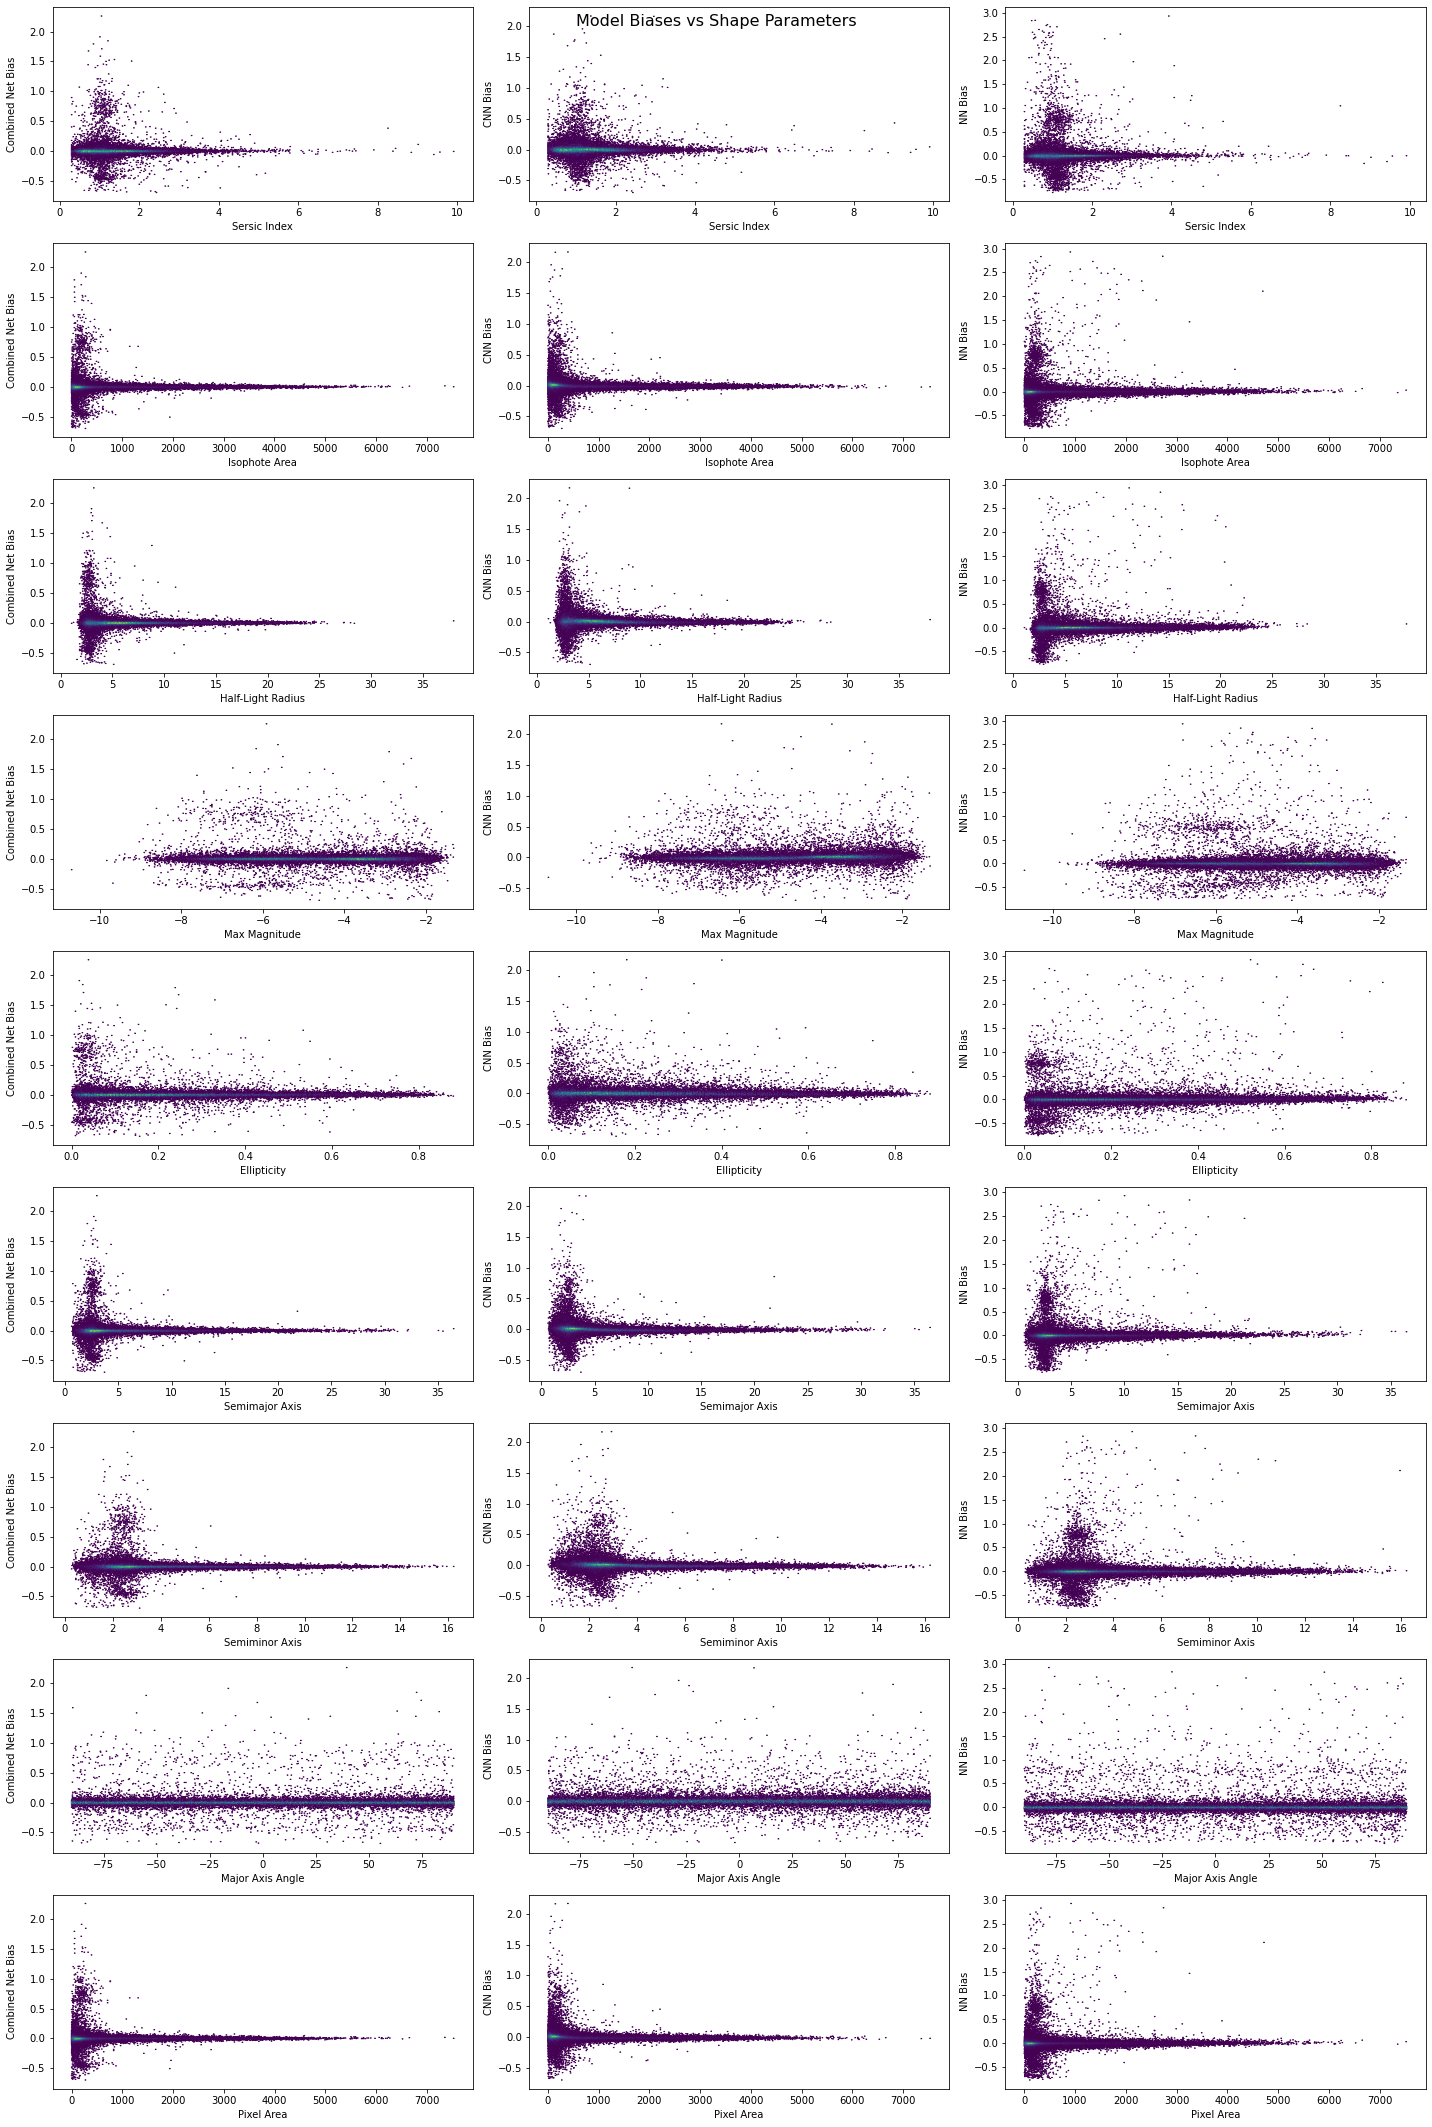

In [11]:
## MODEL BIAS VS SHAPE PARAMS ##
fig, axs = plt.subplots(len(shape_params), 3, figsize=(20,30))
for i, param in enumerate(shape_params):
    for j, model in enumerate(models):
        axs[i,j].hexbin(df[param], df[f'{model}_bias'], gridsize=500, cmap='viridis', mincnt=1)
        axs[i,j].set_xlabel(shape_param_names[i])
        axs[i,j].set_ylabel(f'{model_names[j]} Bias')
fig.suptitle('Model Biases vs Shape Parameters', fontsize=16)
fig.tight_layout() # replace density with metric

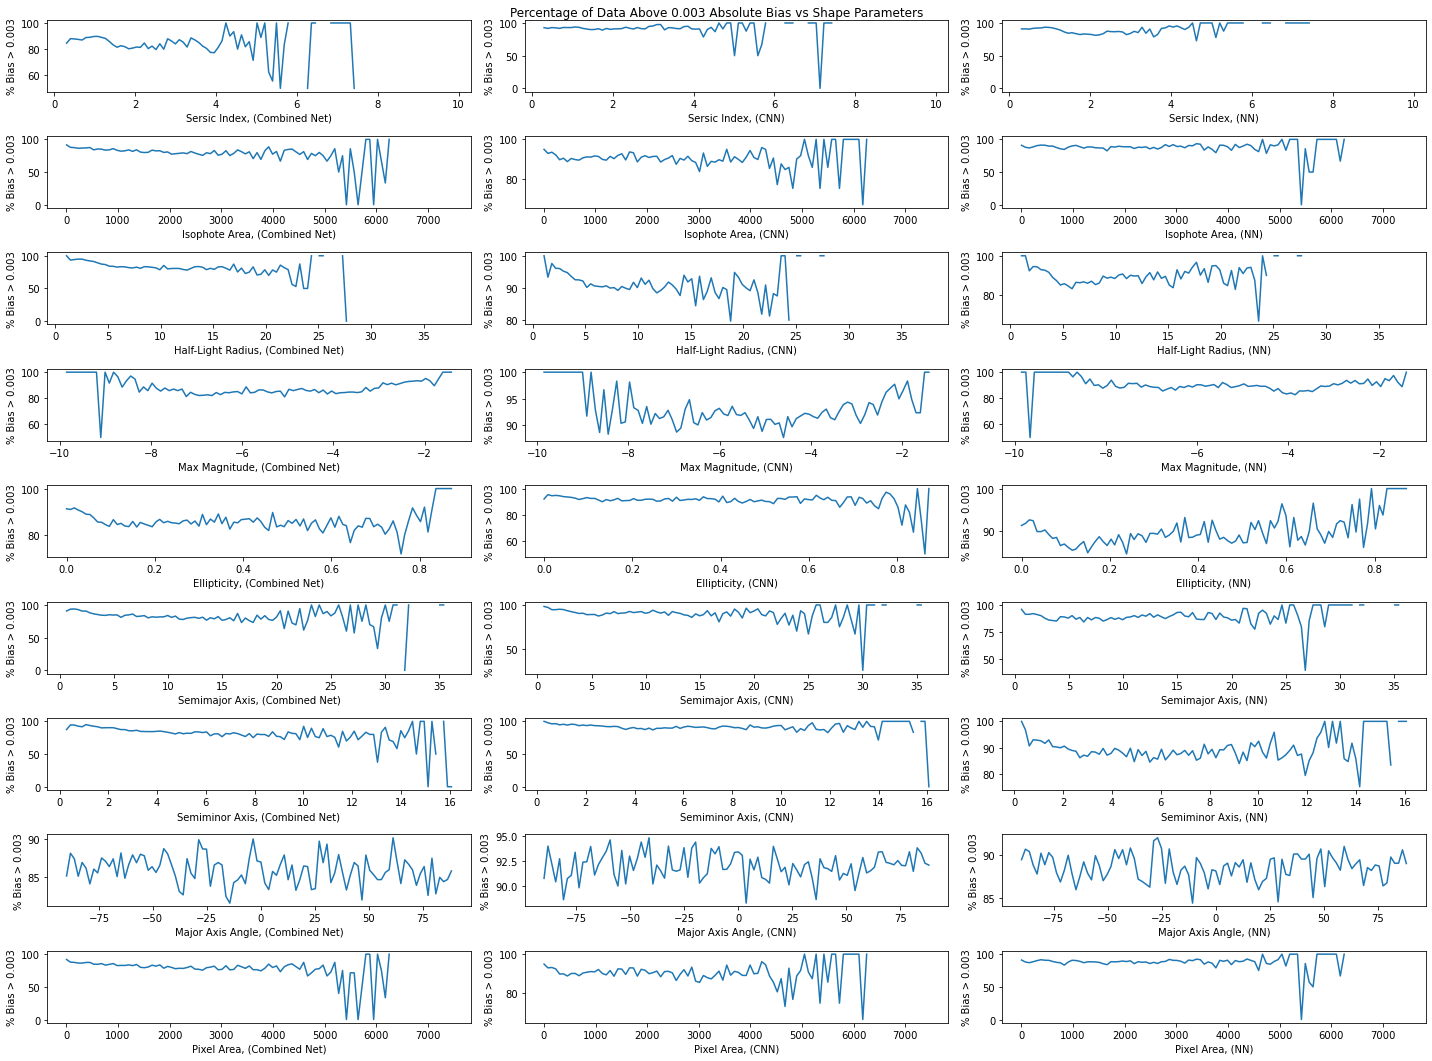

In [12]:
fig, axs = plt.subplots(len(shape_params), len(models), figsize=(20,15))
for i, param in enumerate(shape_params):
    for j, model in enumerate(models):
        nbins = 100
        step = (df[param].max() - df[param].min()) / nbins
        bins = np.arange(df[param].min(), df[param].max() + step, step)
        df[f'{param}_bins'] = pd.cut(df[param], bins=bins)
        bin_error_pct = df.groupby(f'{param}_bins')[f'{model}_abs_bias'].apply(lambda x: (x > 0.003).mean() * 100)
        axs[i,j].plot(bin_error_pct.index.to_series().apply(lambda x: x.left), bin_error_pct.values)
        axs[i,j].set_xlabel(f'{shape_param_names[i]}, ({model_names[j]})')
        axs[i,j].set_ylabel(f'% Bias > 0.003')
fig.suptitle('Percentage of Data Above 0.003 Absolute Bias vs Shape Parameters')
fig.tight_layout()

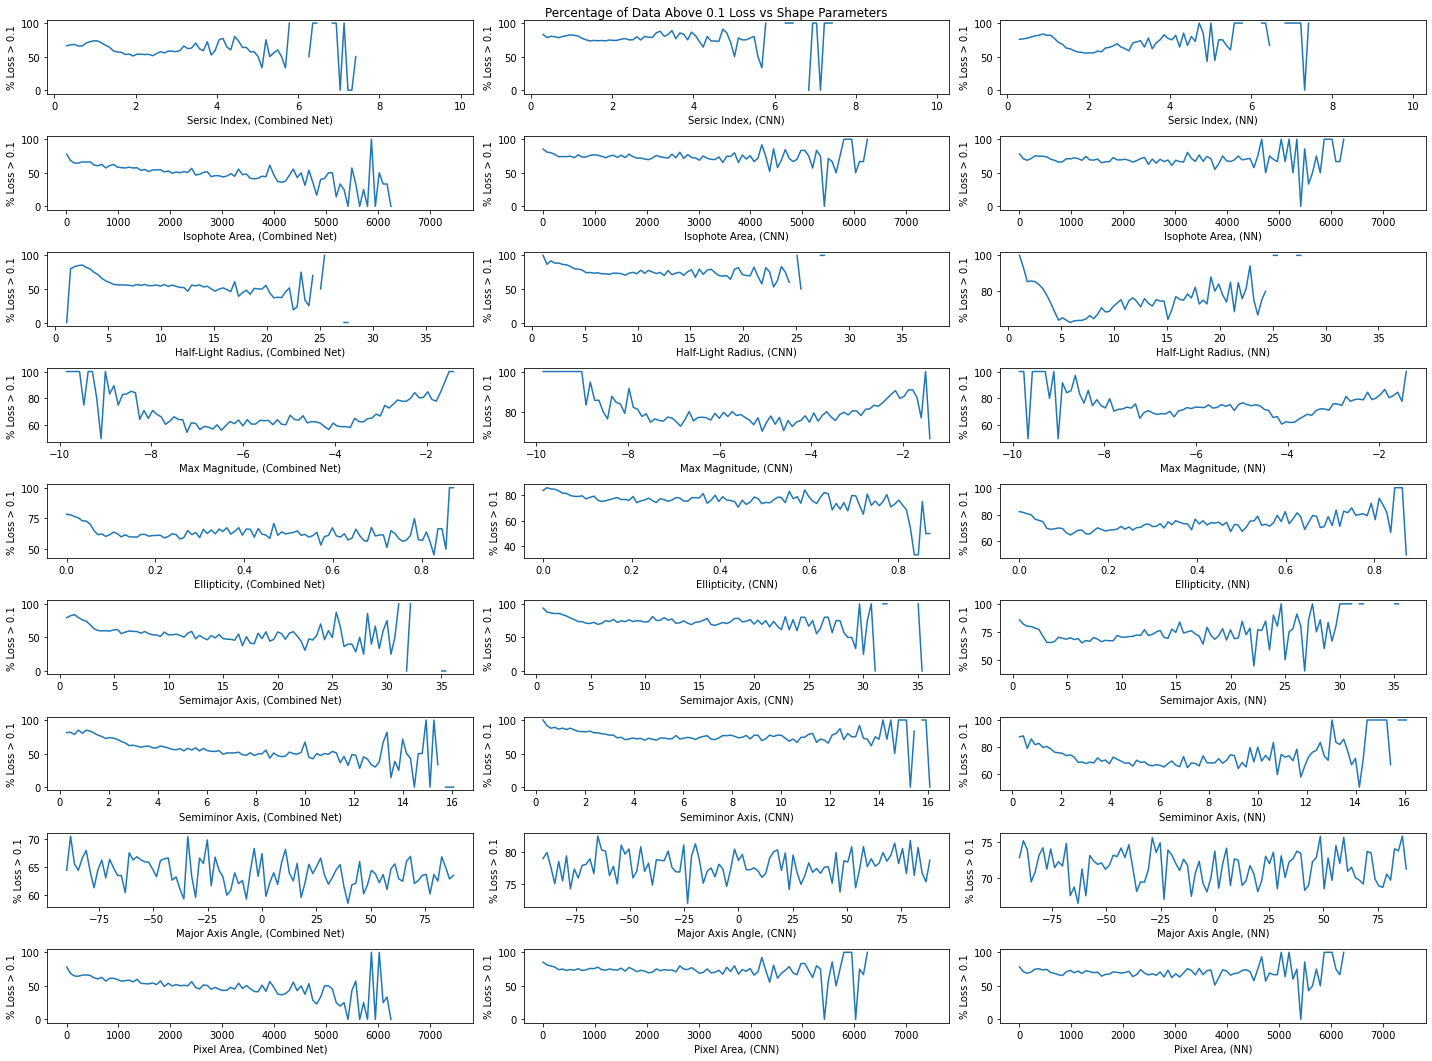

In [13]:
fig, axs = plt.subplots(len(shape_params), len(models), figsize=(20,15))
for i, param in enumerate(shape_params):
    for j, model in enumerate(models):
        nbins = 100
        step = (df[param].max() - df[param].min()) / nbins
        bins = np.arange(df[param].min(), df[param].max() + step, step)
        df[f'{param}_bins'] = pd.cut(df[param], bins=bins)
        bin_error_pct = df.groupby(f'{param}_bins')[f'{model}_loss'].apply(lambda x: (x > 0.003).mean() * 100)
        axs[i,j].plot(bin_error_pct.index.to_series().apply(lambda x: x.left), bin_error_pct.values)
        axs[i,j].set_xlabel(f'{shape_param_names[i]}, ({model_names[j]})')
        axs[i,j].set_ylabel(f'% Loss > 0.1')
fig.suptitle('Percentage of Data Above 0.1 Loss vs Shape Parameters')
fig.tight_layout()
# use the same y axis, or plot multiple models over each

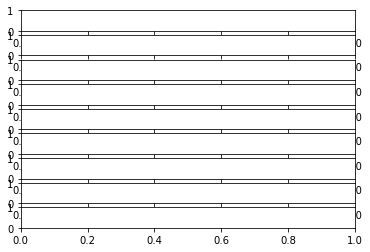

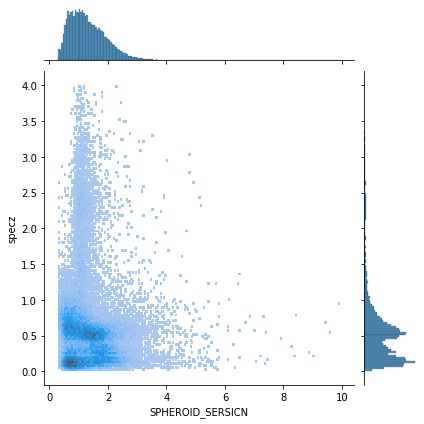

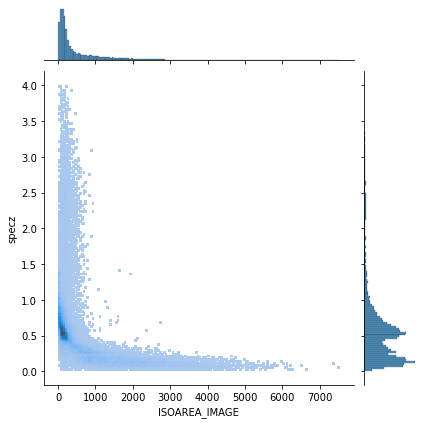

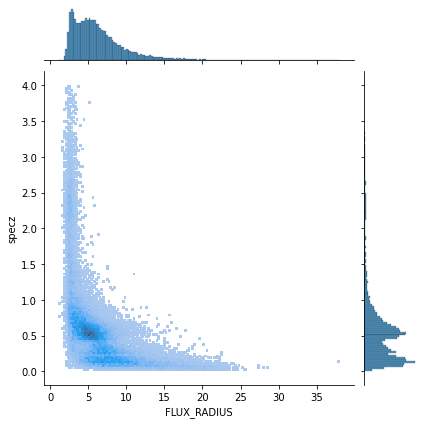

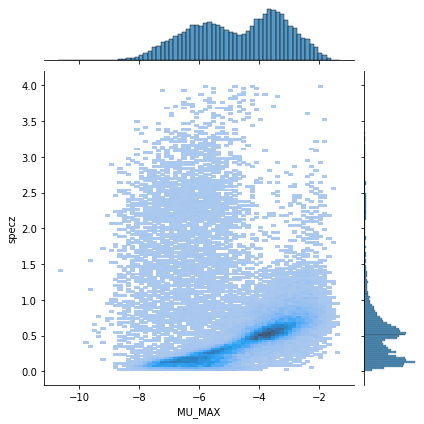

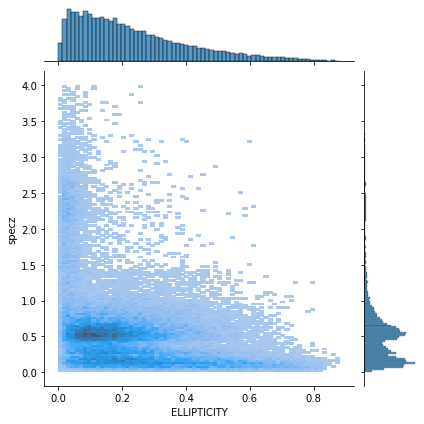

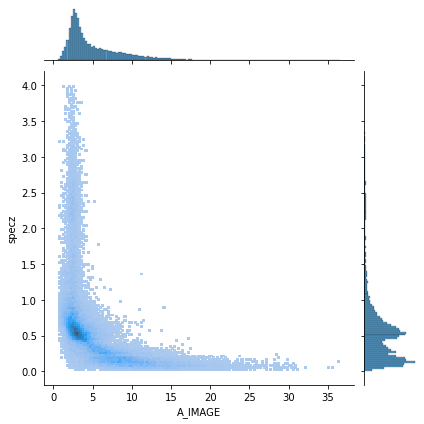

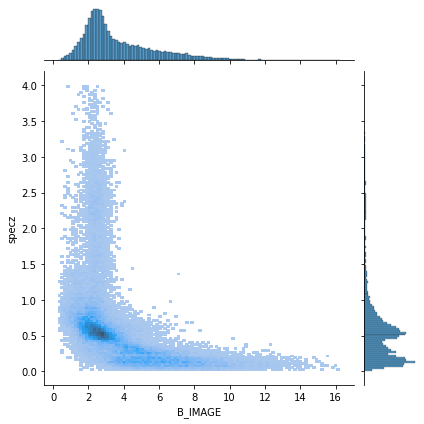

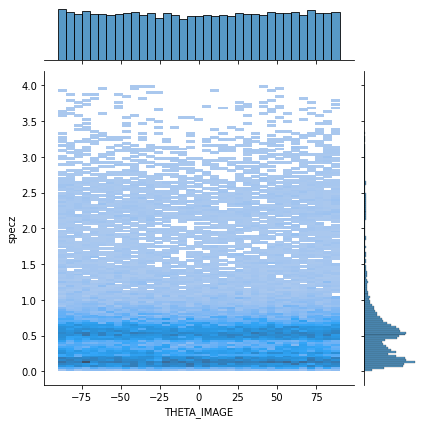

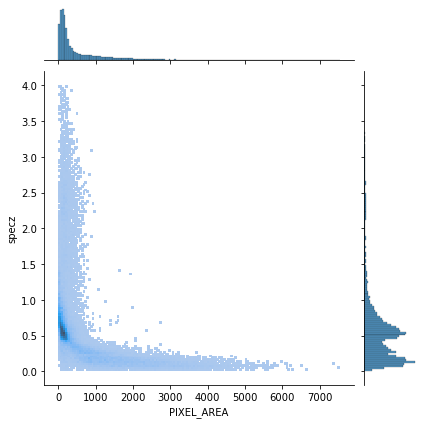

In [14]:
fig, axs = plt.subplots(len(shape_params), 1)
for i, param in enumerate(shape_params):
    sns.jointplot(ax=axs[i], x=df[param], y=df['specz'], kind='hist')

In [15]:
# write document about the pipeline for getting this analyis, like run_sectractor -> features extraction -> mags etc

In [16]:
# for a given sersic index, do low redshift galaxies still perform well?
# look at difference in perfomance between low and highest redshifts, if a gap at a given shape parameter is comparable, the shape info matters

In [17]:
# scatter plot, color by redshift, total area vs metric (rmse, bias)
# ax_ = ax.scatter(x,y, marker='+', c = zspec,s = 1, ,vmin=0, vmax=4)
# plt.colorbar(ax_)



In [18]:
# higher area galalxies are exclusive to low redshifts
# so do these galaxies perform better because of the image properties, or because they are in a strata that is overrepresented?
# so well performing galaxies might be low redshift and high area. or perhaps the area doesn't better because most high area
# gals are low redshift anyway. thus, limiting redshift to low values might be more fruitful

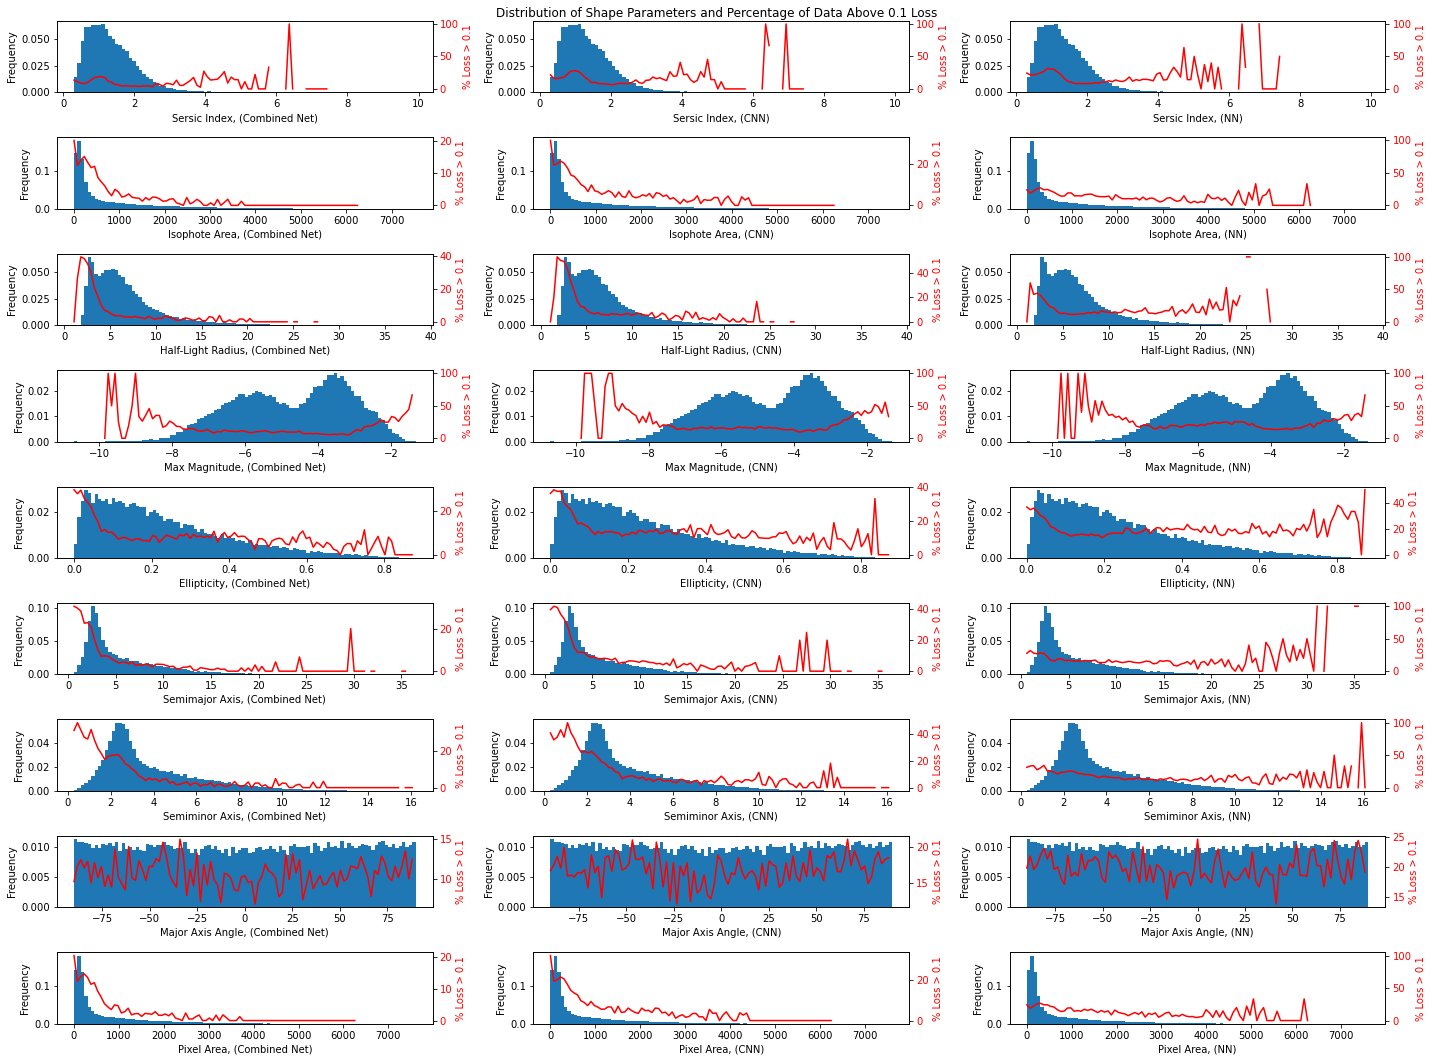

In [19]:
fig, axs = plt.subplots(len(shape_params), len(models), figsize=(20,15))
for i, param in enumerate(shape_params):
    for j, model in enumerate(models):
        nbins = 100
        step = (df[param].max() - df[param].min()) / nbins
        bins = np.arange(df[param].min(), df[param].max() + step, step)
        df[f'{param}_bins'] = pd.cut(df[param], bins=bins)
        bin_error_pct = df.groupby(f'{param}_bins')[f'{model}_loss'].apply(lambda x: (x > 0.1).mean() * 100)
        axs[i,j].hist(df[param], bins=bins, weights=np.ones(len(df[param])) / len(df[param]))
        axs[i,j].set_xlabel(f'{shape_param_names[i]}, ({model_names[j]})')
        axs[i,j].set_ylabel('Frequency')
        twin_ax = axs[i,j].twinx()
        twin_ax.plot(bin_error_pct.index.to_series().apply(lambda x: x.left), bin_error_pct.values, color='r')
        twin_ax.set_ylabel(f'% Loss > 0.1', color='r')
        twin_ax.tick_params(axis='y', labelcolor='r')
fig.suptitle('Distribution of Shape Parameters and Percentage of Data Above 0.1 Loss')
fig.tight_layout()

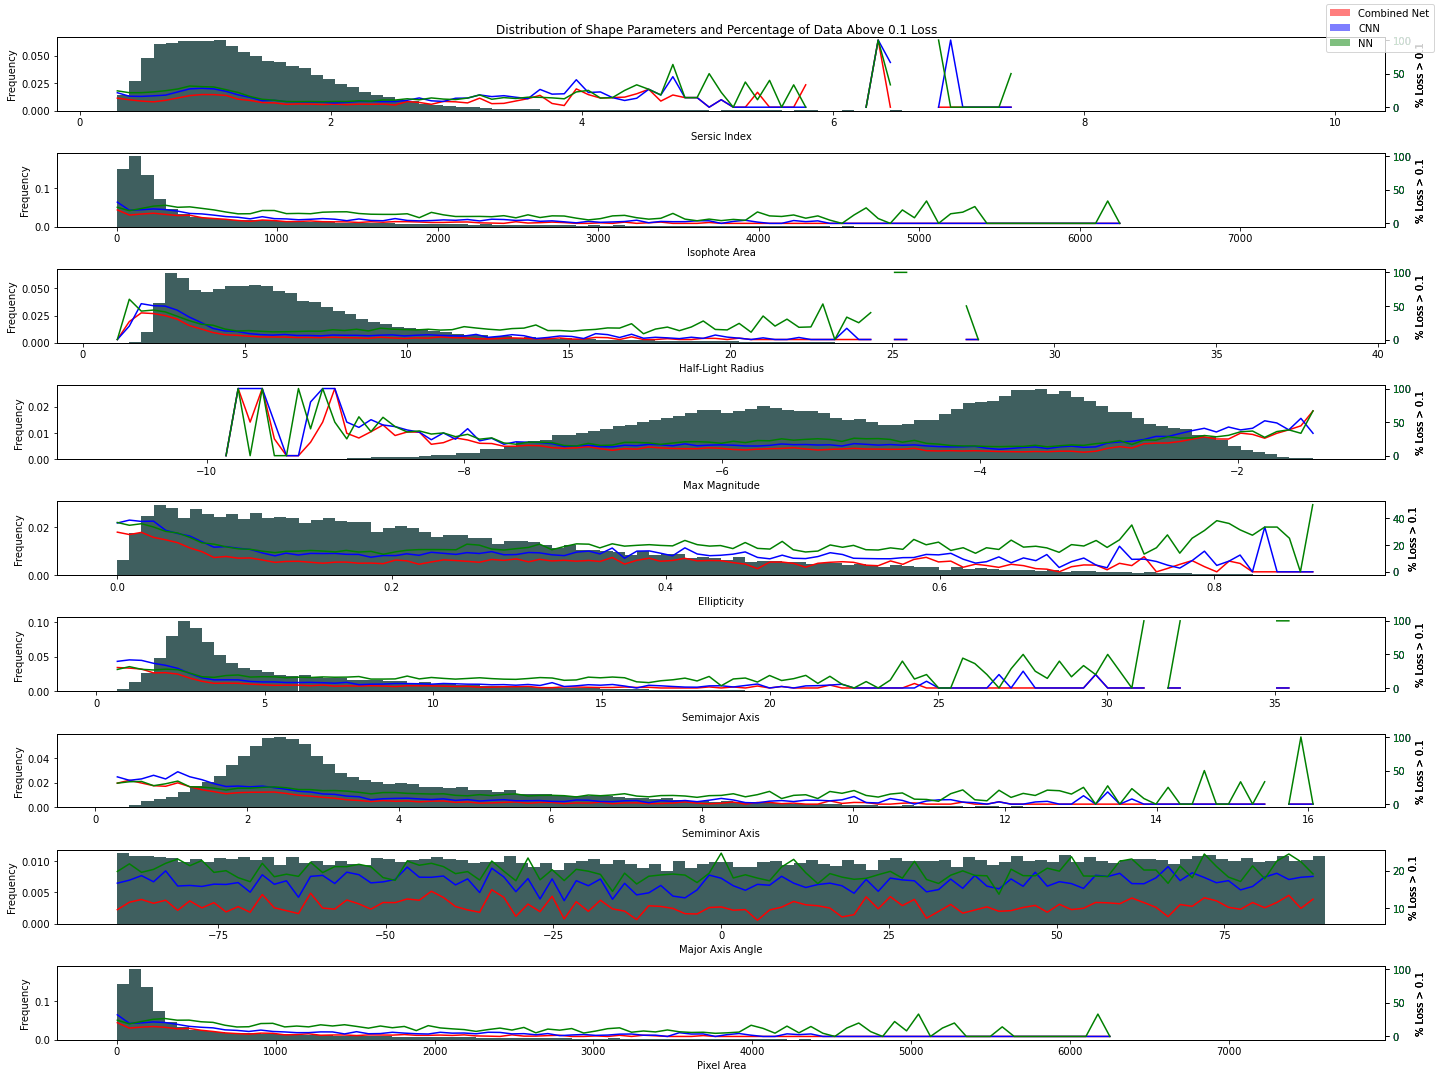

In [20]:
fig, axs = plt.subplots(len(shape_params), 1, figsize=(20,15))
colors = ['r', 'b', 'g']
for i, param in enumerate(shape_params):
    nbins = 100
    step = (df[param].max() - df[param].min()) / nbins
    bins = np.arange(df[param].min(), df[param].max() + step, step)
    df[f'{param}_bins'] = pd.cut(df[param], bins=bins)
    for j, model in enumerate(models):
        bin_error_pct = df.groupby(f'{param}_bins')[f'{model}_loss'].apply(lambda x: (x > 0.1).mean() * 100)
        axs[i].hist(df[param], bins=bins, weights=np.ones(len(df[param])) / len(df[param]), alpha=0.5, color=colors[j], label=model_names[j])
        twin_ax = axs[i].twinx()
        twin_ax.plot(bin_error_pct.index.to_series().apply(lambda x: x.left), bin_error_pct.values, color=colors[j])
        twin_ax.set_ylabel(f'% Loss > 0.1')
        twin_ax.tick_params(axis='y', labelcolor=colors[j])
        if j > 0:
            twin_ax.get_shared_y_axes().join(prev_twin_ax, twin_ax)
        prev_twin_ax = twin_ax
    axs[i].set_xlabel(f'{shape_param_names[i]}')
    axs[i].set_ylabel('Frequency')
fig.suptitle('Distribution of Shape Parameters and Percentage of Data Above 0.1 Loss')
fig.tight_layout()
fig.legend(model_names, loc='upper right')


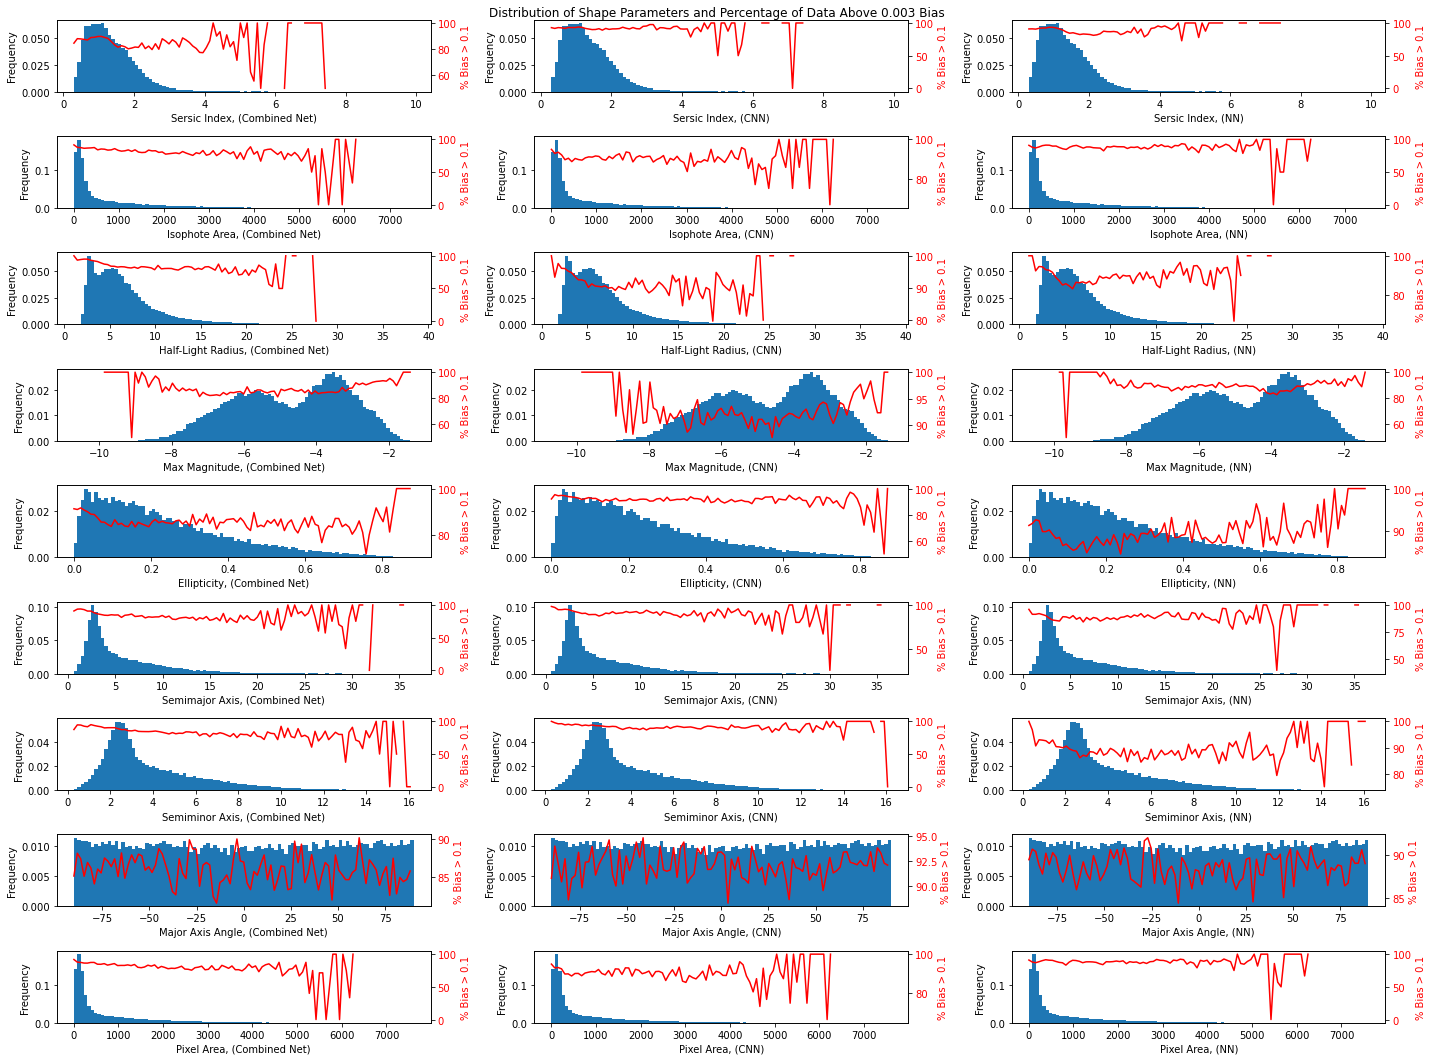

In [21]:
fig, axs = plt.subplots(len(shape_params), len(models), figsize=(20,15))
for i, param in enumerate(shape_params):
    for j, model in enumerate(models):
        nbins = 100
        step = (df[param].max() - df[param].min()) / nbins
        bins = np.arange(df[param].min(), df[param].max() + step, step)
        df[f'{param}_bins'] = pd.cut(df[param], bins=bins)
        bin_error_pct = df.groupby(f'{param}_bins')[f'{model}_bias'].apply(lambda x: (np.abs(x) > 0.003).mean() * 100)
        axs[i,j].hist(df[param], bins=bins, weights=np.ones(len(df[param])) / len(df[param]))
        axs[i,j].set_xlabel(f'{shape_param_names[i]}, ({model_names[j]})')
        axs[i,j].set_ylabel('Frequency')
        twin_ax = axs[i,j].twinx()
        twin_ax.plot(bin_error_pct.index.to_series().apply(lambda x: x.left), bin_error_pct.values, color='r')
        twin_ax.set_ylabel(f'% Bias > 0.1', color='r')
        twin_ax.tick_params(axis='y', labelcolor='r')
fig.suptitle('Distribution of Shape Parameters and Percentage of Data Above 0.003 Bias')
fig.tight_layout()


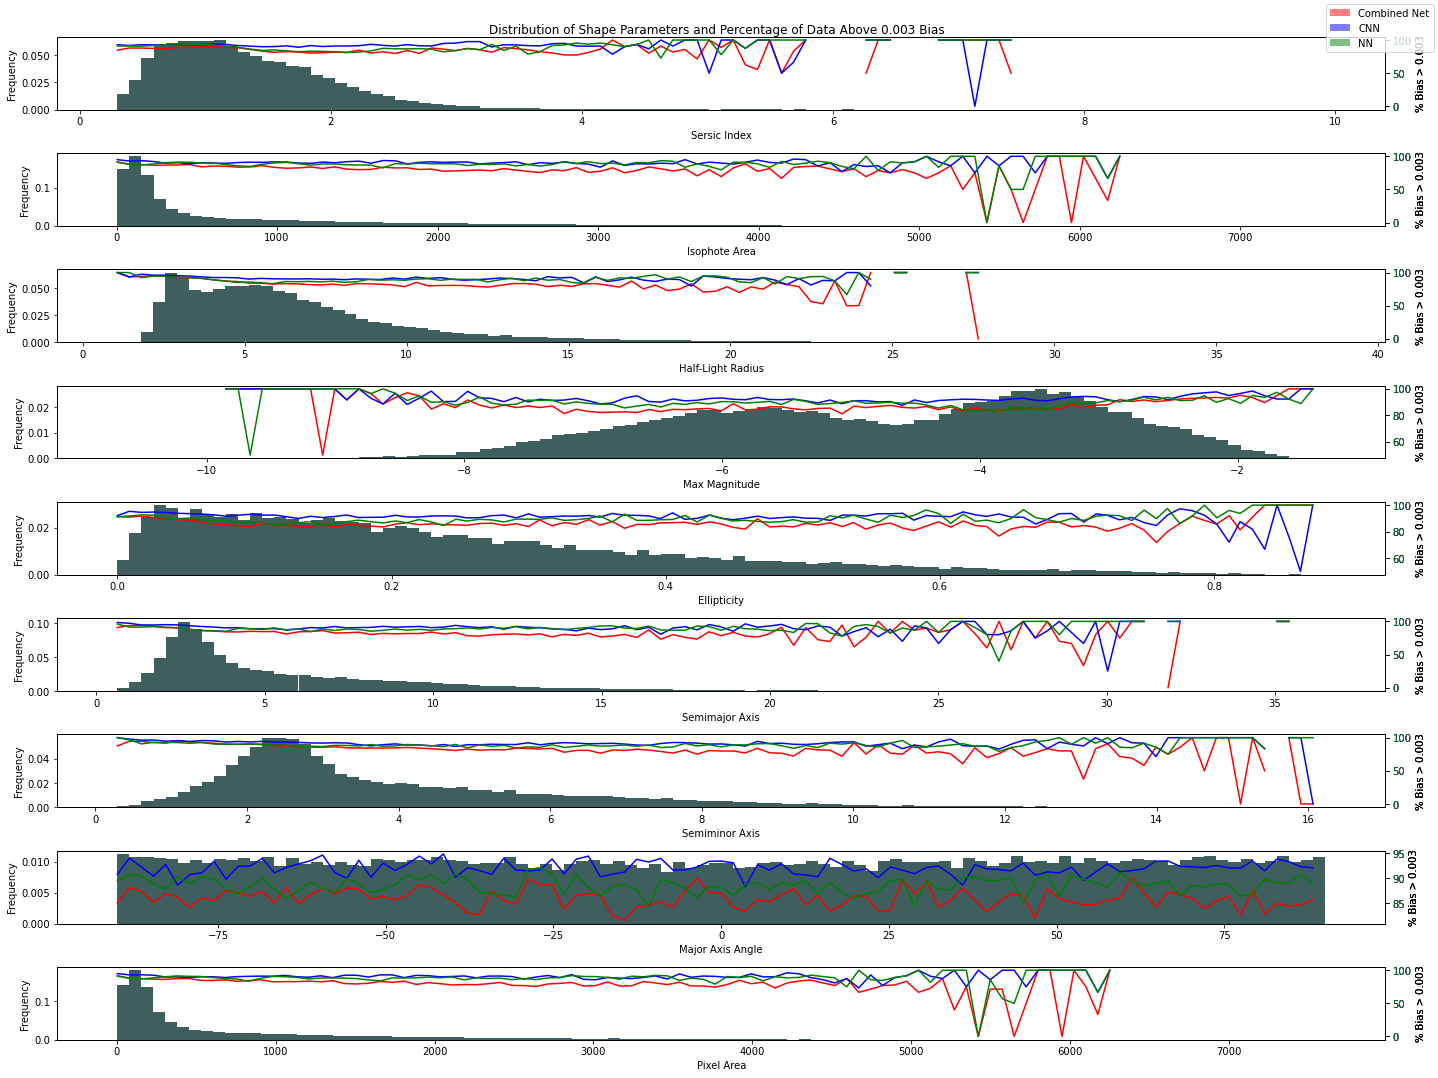

In [22]:
fig, axs = plt.subplots(len(shape_params), 1, figsize=(20,15))
colors = ['r', 'b', 'g']
for i, param in enumerate(shape_params):
    nbins = 100
    step = (df[param].max() - df[param].min()) / nbins
    bins = np.arange(df[param].min(), df[param].max() + step, step)
    df[f'{param}_bins'] = pd.cut(df[param], bins=bins)
    for j, model in enumerate(models):
        bin_error_pct = df.groupby(f'{param}_bins')[f'{model}_bias'].apply(lambda x: (np.abs(x) > 0.003).mean() * 100)
        axs[i].hist(df[param], bins=bins, weights=np.ones(len(df[param])) / len(df[param]), alpha=0.5, color=colors[j], label=model_names[j])
        twin_ax = axs[i].twinx()
        twin_ax.plot(bin_error_pct.index.to_series().apply(lambda x: x.left), bin_error_pct.values, color=colors[j])
        twin_ax.set_ylabel(f'% Bias > 0.003')
        twin_ax.tick_params(axis='y', labelcolor=colors[j])
        if j > 0:
            twin_ax.get_shared_y_axes().join(prev_twin_ax, twin_ax)
        prev_twin_ax = twin_ax
    axs[i].set_xlabel(f'{shape_param_names[i]}')
    axs[i].set_ylabel('Frequency')
fig.suptitle('Distribution of Shape Parameters and Percentage of Data Above 0.003 Bias')
fig.tight_layout()
fig.legend(model_names, loc='upper right')


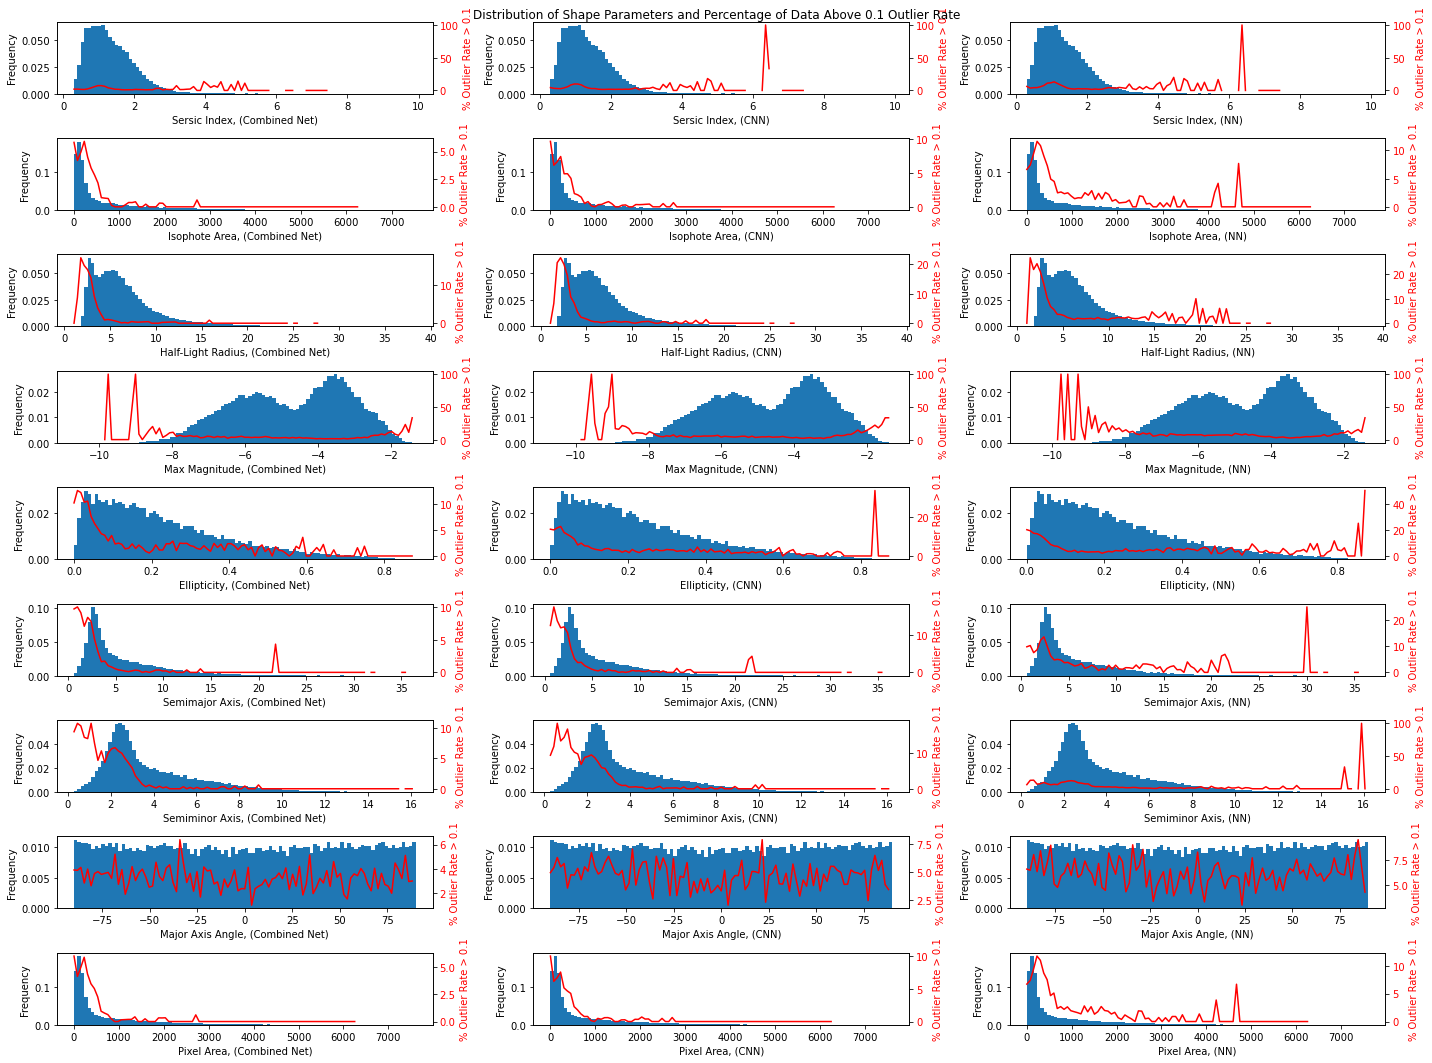

In [23]:
fig, axs = plt.subplots(len(shape_params), len(models), figsize=(20,15))
for i, param in enumerate(shape_params):
    for j, model in enumerate(models):
        nbins = 100
        step = (df[param].max() - df[param].min()) / nbins
        bins = np.arange(df[param].min(), df[param].max() + step, step)
        df[f'{param}_bins'] = pd.cut(df[param], bins=bins)
        bin_error_pct = df.groupby(f'{param}_bins')[f'{model}_outlier_rate'].apply(lambda x: (x > 0.1).mean() * 100)
        axs[i,j].hist(df[param], bins=bins, weights=np.ones(len(df[param])) / len(df[param]))
        axs[i,j].set_xlabel(f'{shape_param_names[i]}, ({model_names[j]})')
        axs[i,j].set_ylabel('Frequency')
        twin_ax = axs[i,j].twinx()
        twin_ax.plot(bin_error_pct.index.to_series().apply(lambda x: x.left), bin_error_pct.values, color='r')
        twin_ax.set_ylabel(f'% Outlier Rate > 0.1', color='r')
        twin_ax.tick_params(axis='y', labelcolor='r')
fig.suptitle('Distribution of Shape Parameters and Percentage of Data Above 0.1 Outlier Rate')
fig.tight_layout()


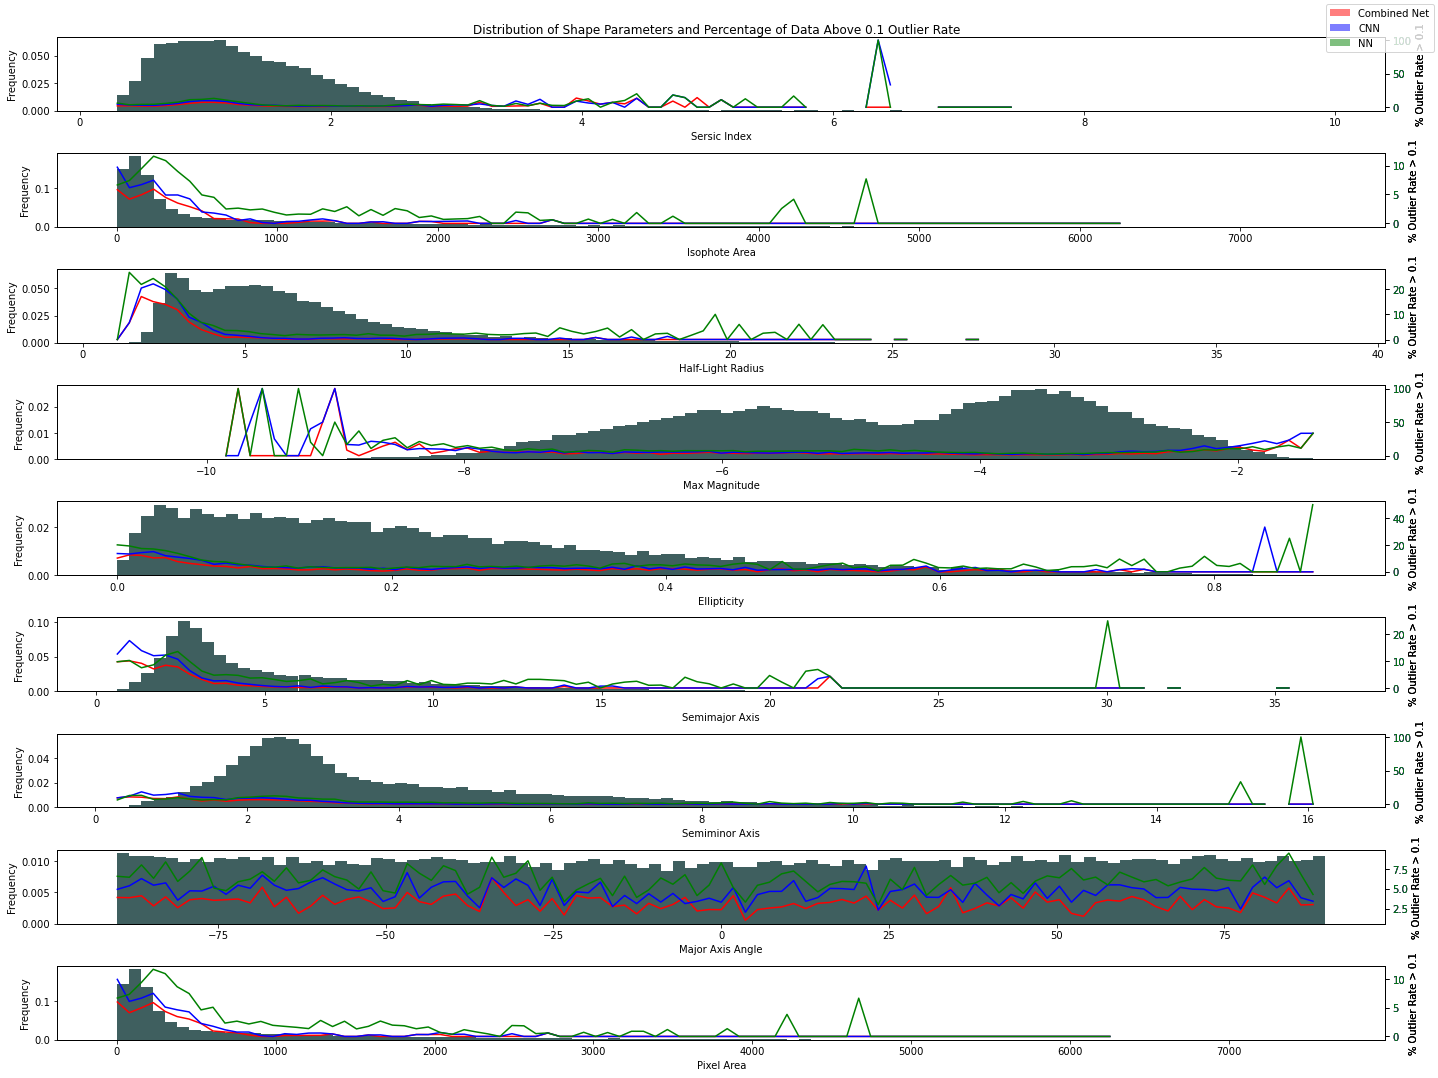

In [24]:
fig, axs = plt.subplots(len(shape_params), 1, figsize=(20,15))
colors = ['r', 'b', 'g']
for i, param in enumerate(shape_params):
    nbins = 100
    step = (df[param].max() - df[param].min()) / nbins
    bins = np.arange(df[param].min(), df[param].max() + step, step)
    df[f'{param}_bins'] = pd.cut(df[param], bins=bins)
    for j, model in enumerate(models):
        bin_error_pct = df.groupby(f'{param}_bins')[f'{model}_outlier_rate'].apply(lambda x: (x > 0.1).mean() * 100)
        axs[i].hist(df[param], bins=bins, weights=np.ones(len(df[param])) / len(df[param]), alpha=0.5, color=colors[j], label=model_names[j])
        twin_ax = axs[i].twinx()
        twin_ax.plot(bin_error_pct.index.to_series().apply(lambda x: x.left), bin_error_pct.values, color=colors[j])
        twin_ax.set_ylabel(f'% Outlier Rate > 0.1')
        twin_ax.tick_params(axis='y', labelcolor=colors[j])
        if j > 0:
            twin_ax.get_shared_y_axes().join(prev_twin_ax, twin_ax)
        prev_twin_ax = twin_ax
    axs[i].set_xlabel(f'{shape_param_names[i]}')
    axs[i].set_ylabel('Frequency')
fig.suptitle('Distribution of Shape Parameters and Percentage of Data Above 0.1 Outlier Rate')
fig.tight_layout()
fig.legend(model_names, loc='upper right')


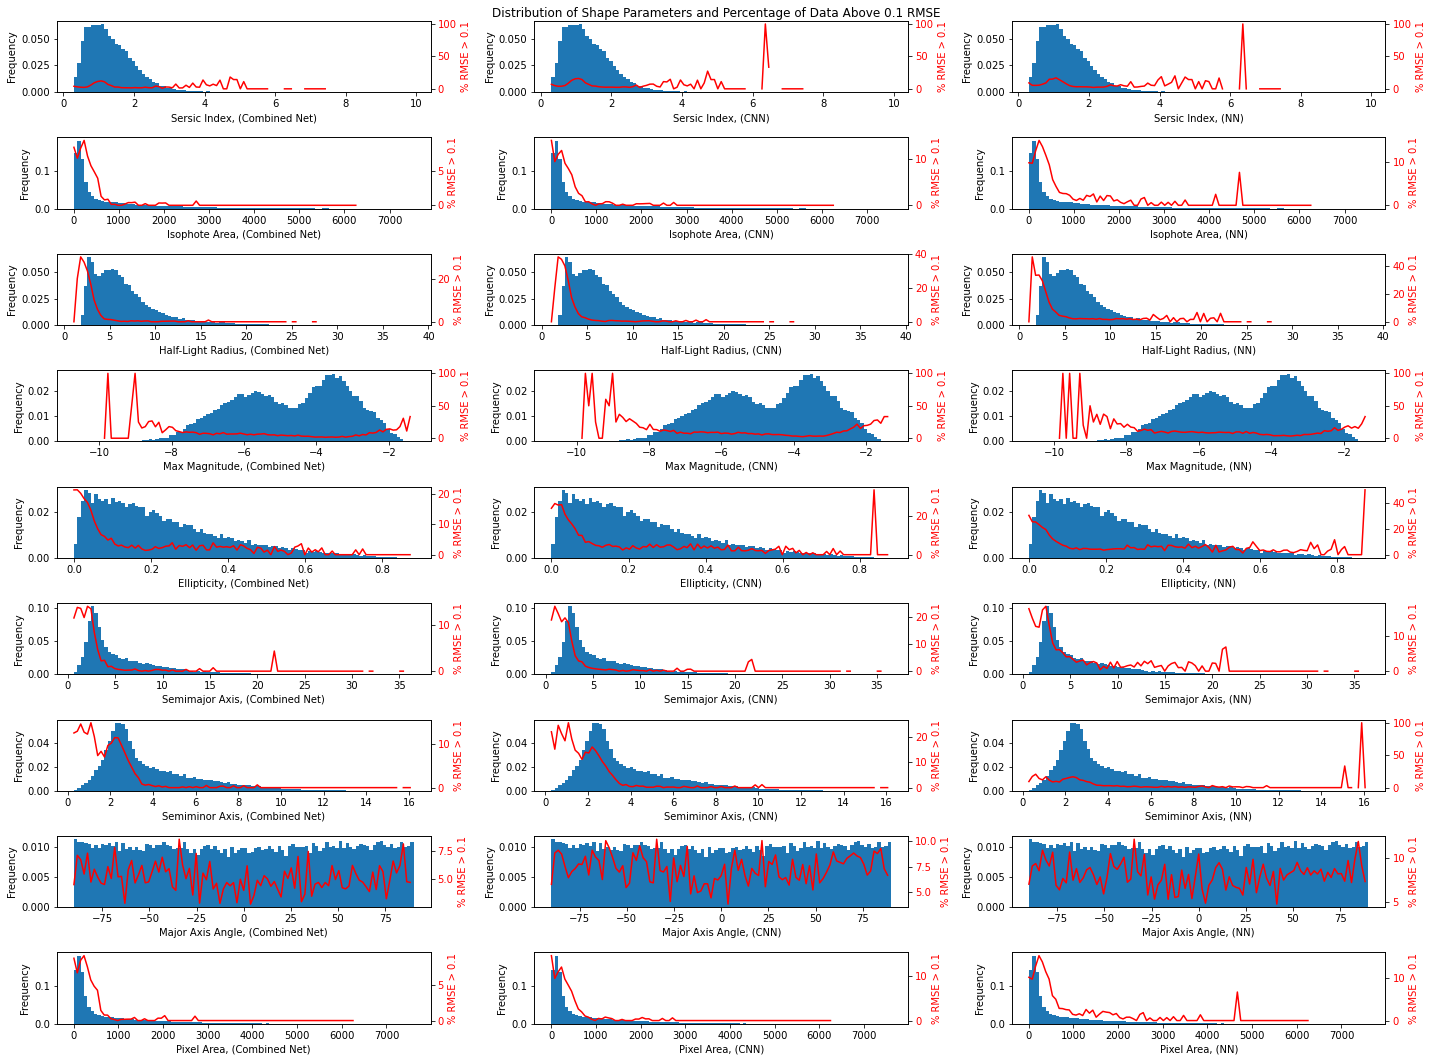

In [25]:
fig, axs = plt.subplots(len(shape_params), len(models), figsize=(20,15))
for i, param in enumerate(shape_params):
    for j, model in enumerate(models):
        nbins = 100
        step = (df[param].max() - df[param].min()) / nbins
        bins = np.arange(df[param].min(), df[param].max() + step, step)
        df[f'{param}_bins'] = pd.cut(df[param], bins=bins)
        bin_error_pct = df.groupby(f'{param}_bins')[f'{model}_rmse'].apply(lambda x: (x > 0.2).mean() * 100)
        axs[i,j].hist(df[param], bins=bins, weights=np.ones(len(df[param])) / len(df[param]))
        axs[i,j].set_xlabel(f'{shape_param_names[i]}, ({model_names[j]})')
        axs[i,j].set_ylabel('Frequency')
        twin_ax = axs[i,j].twinx()
        twin_ax.plot(bin_error_pct.index.to_series().apply(lambda x: x.left), bin_error_pct.values, color='r')
        twin_ax.set_ylabel(f'% RMSE > 0.1', color='r')
        twin_ax.tick_params(axis='y', labelcolor='r')
fig.suptitle('Distribution of Shape Parameters and Percentage of Data Above 0.1 RMSE')
fig.tight_layout()


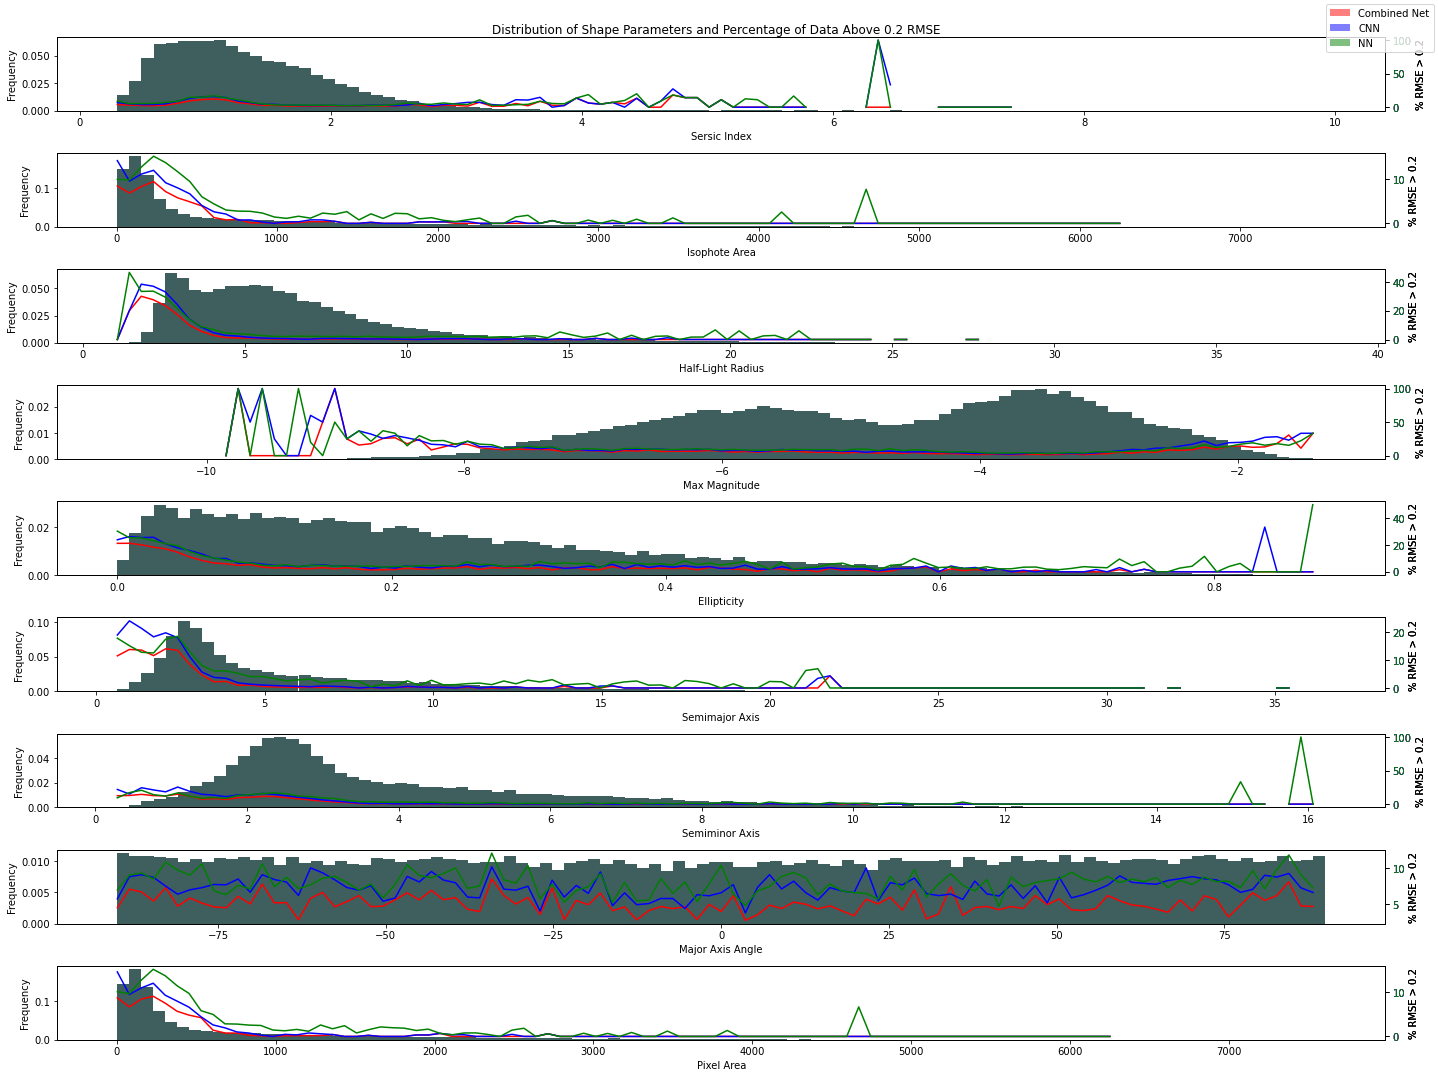

In [26]:
fig, axs = plt.subplots(len(shape_params), 1, figsize=(20,15))
colors = ['r', 'b', 'g']
for i, param in enumerate(shape_params):
    nbins = 100
    step = (df[param].max() - df[param].min()) / nbins
    bins = np.arange(df[param].min(), df[param].max() + step, step)
    df[f'{param}_bins'] = pd.cut(df[param], bins=bins)
    for j, model in enumerate(models):
        bin_error_pct = df.groupby(f'{param}_bins')[f'{model}_rmse'].apply(lambda x: (x > 0.2).mean() * 100)
        axs[i].hist(df[param], bins=bins, weights=np.ones(len(df[param])) / len(df[param]), alpha=0.5, color=colors[j], label=model_names[j])
        twin_ax = axs[i].twinx()
        twin_ax.plot(bin_error_pct.index.to_series().apply(lambda x: x.left), bin_error_pct.values, color=colors[j])
        twin_ax.set_ylabel(f'% RMSE > 0.2')
        twin_ax.tick_params(axis='y', labelcolor=colors[j])
        if j > 0:
            twin_ax.get_shared_y_axes().join(prev_twin_ax, twin_ax)
        prev_twin_ax = twin_ax
    axs[i].set_xlabel(f'{shape_param_names[i]}')
    axs[i].set_ylabel('Frequency')
fig.suptitle('Distribution of Shape Parameters and Percentage of Data Above 0.2 RMSE')
fig.tight_layout()
fig.legend(model_names, loc='upper right')


<ipython-input-38-7b5283b76b59>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  crowded_df[f'{param}_bins'] = pd.cut(crowded_df[param], bins=bins_c)
<ipython-input-38-7b5283b76b59>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  crowded_df[f'{param}_bins'] = pd.cut(crowded_df[param], bins=bins_c)
<ipython-input-38-7b5283b76b59>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the do

<ipython-input-38-7b5283b76b59>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  crowded_df[f'{param}_bins'] = pd.cut(crowded_df[param], bins=bins_c)
<ipython-input-38-7b5283b76b59>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  crowded_df[f'{param}_bins'] = pd.cut(crowded_df[param], bins=bins_c)
<ipython-input-38-7b5283b76b59>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the do

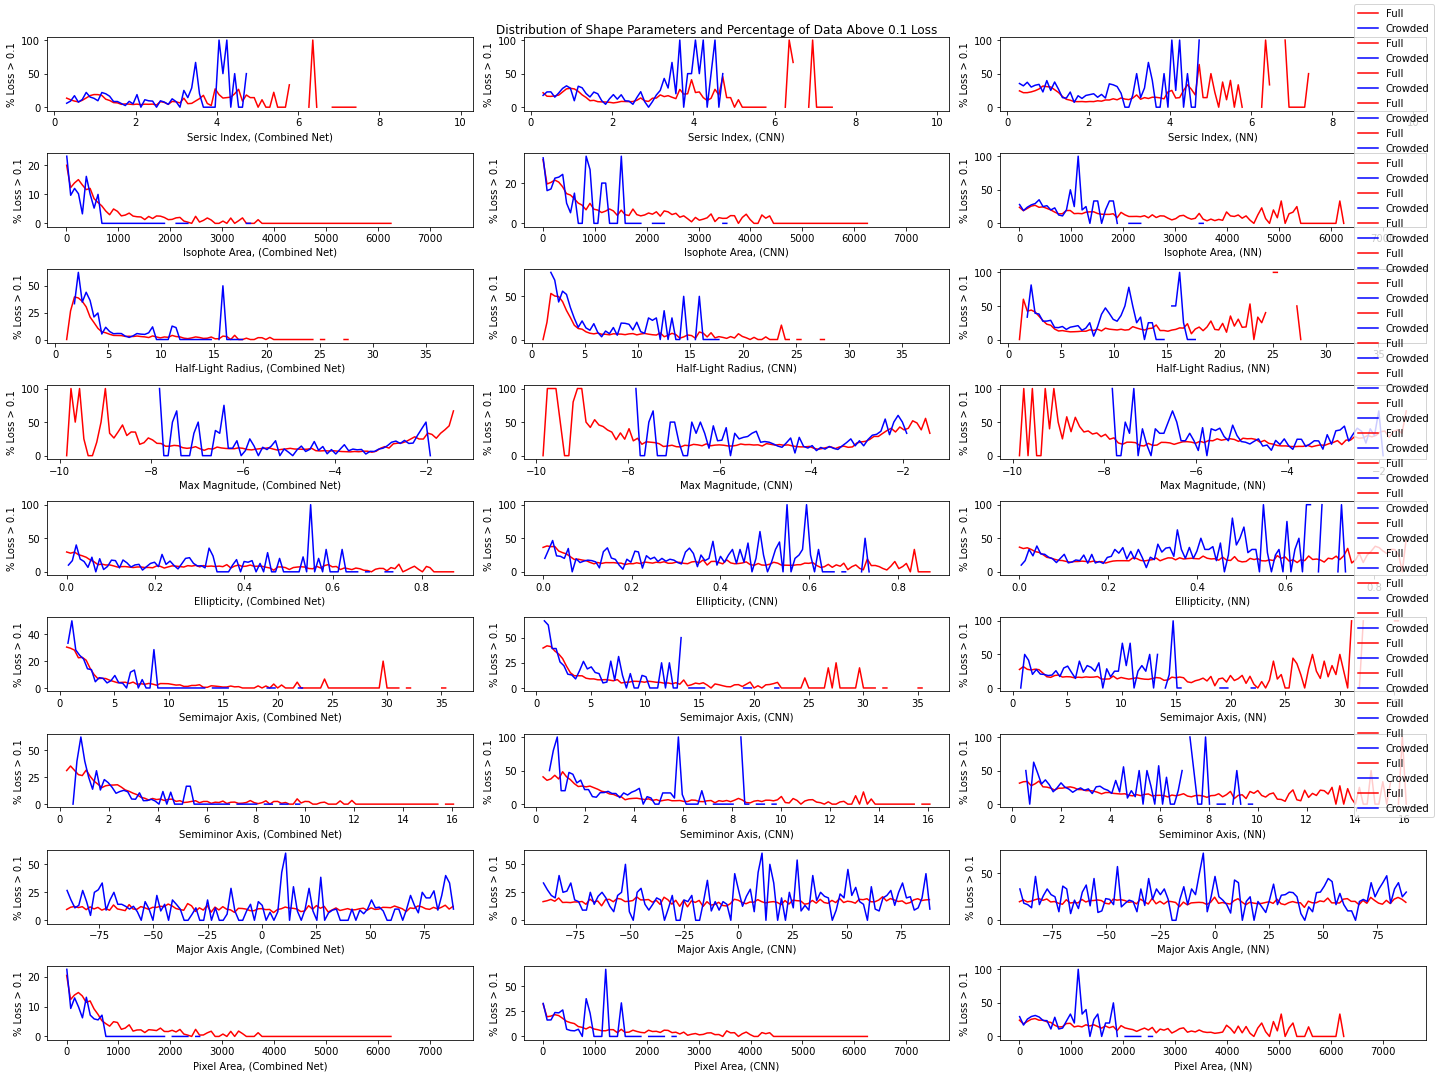

In [38]:
fig, axs = plt.subplots(len(shape_params), len(models), figsize=(20,15))
for i, param in enumerate(shape_params):
    for j, model in enumerate(models):
        nbins = 100
        step = (df[param].max() - df[param].min()) / nbins
        bins = np.arange(df[param].min(), df[param].max() + step, step)
        df[f'{param}_bins'] = pd.cut(df[param], bins=bins)
        bin_error_pct = df.groupby(f'{param}_bins')[f'{model}_loss'].apply(lambda x: (x > 0.1).mean() * 100)
        
        step_c = (crowded_df[param].max() - crowded_df[param].min()) / nbins
        bins_c = np.arange(crowded_df[param].min(), crowded_df[param].max() + step, step)
        crowded_df[f'{param}_bins'] = pd.cut(crowded_df[param], bins=bins_c)
        bin_error_pct_c = crowded_df.groupby(f'{param}_bins')[f'{model}_loss'].apply(lambda x: (x > 0.1).mean() * 100)
        
        axs[i,j].plot(bin_error_pct.index.to_series().apply(lambda x: x.left), bin_error_pct.values, color='r', label='Full')
        axs[i,j].plot(bin_error_pct_c.index.to_series().apply(lambda x: x.left), bin_error_pct_c.values, color='b', label='Crowded')
        axs[i,j].set_xlabel(f'{shape_param_names[i]}, ({model_names[j]})')
        axs[i,j].set_ylabel(f'% Loss > 0.1')
fig.suptitle('Distribution of Shape Parameters and Percentage of Data Above 0.1 Loss')
fig.tight_layout()
fig.legend()